# EA4 Backtest

In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========= FILES =========
CAND_FILE = '../src_csv/xau_m5_candidates_ea2.csv'
M1_FILE   = '../src_csv/m1_master.csv'

POINT         = 0.01
USD_PER_POINT = 0.01
START_BALANCE = 100.0
SPREAD_PTS    = 8
SPREAD        = SPREAD_PTS * POINT

START_ALL = '2026-02-01 00:00'
END_ALL   = '2026-02-20 23:59'

## Load Data

In [420]:
cand = pd.read_csv(CAND_FILE)
cand.columns = cand.columns.str.strip()
cand['time'] = pd.to_datetime(cand['time'])
cand = cand.sort_values('time')

m1 = pd.read_csv(M1_FILE)
m1.columns = m1.columns.str.strip()
m1['time'] = pd.to_datetime(m1['time'])
m1 = m1.sort_values('time').set_index('time')

cand = cand[
    (cand['time'] >= START_ALL) &
    (cand['time'] <= END_ALL)
].copy()

def get_session(h):
    if h < 8:    return 'Asia'
    elif h < 16: return 'Europe'
    else:        return 'America'

cand['hour']    = cand['time'].dt.hour
cand['session'] = cand['hour'].apply(get_session)
cand['date']    = cand['time'].dt.date

print(f'Candidates : {len(cand)}')
print(f'M1 rows    : {len(m1)}')
cand.head()

Candidates : 4107
M1 rows    : 102337


,time,side,spread_pts,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,hour,session,date
76026,2026-02-02 01:00:00,SELL,29,-6652.0,1115.0,1832.0,433.0,587.0,-2149.0,177.0,-880.0,2478.0,1859.0,1,Asia,2026-02-02
76027,2026-02-02 01:05:00,SELL,154,-1238.0,-6652.0,1115.0,1832.0,433.0,587.0,-2149.0,177.0,-880.0,2478.0,1,Asia,2026-02-02
76028,2026-02-02 01:10:00,SELL,4,-7451.0,-1238.0,-6652.0,1115.0,1832.0,433.0,587.0,-2149.0,177.0,-880.0,1,Asia,2026-02-02
76029,2026-02-02 01:15:00,SELL,4,-2282.0,-7451.0,-1238.0,-6652.0,1115.0,1832.0,433.0,587.0,-2149.0,177.0,1,Asia,2026-02-02
76030,2026-02-02 01:20:00,BUY,4,289.0,-2282.0,-7451.0,-1238.0,-6652.0,1115.0,1832.0,433.0,587.0,-2149.0,1,Asia,2026-02-02


## Pre-compute M1 Windows

In [421]:
MAX_LOOKFORWARD = 120  # must be >= MAX_MINUTES below

m1_close = m1['close'].values
m1_times = m1.index
m1_pos   = {t: i for i, t in enumerate(m1_times)}

records = []

for _, row in cand.iterrows():
    t0      = row['time']
    side    = row['side']
    t_entry = t0 + pd.Timedelta(minutes=4)

    if t_entry not in m1_pos:
        continue

    idx         = m1_pos[t_entry]
    entry_close = m1_close[idx]
    entry       = entry_close + SPREAD/2 if side == 'BUY' else entry_close - SPREAD/2

    end_idx  = min(idx + 1 + MAX_LOOKFORWARD, len(m1_close))
    future_c = m1_close[idx+1 : end_idx]
    future_t = m1_times[idx+1 : end_idx]

    if len(future_c) == 0:
        continue

    records.append({
        'time':    t0,
        'side':    1 if side == 'BUY' else -1,
        'entry':   entry,
        'bid':     future_c - SPREAD/2,
        'ask':     future_c + SPREAD/2,
        'exit_t':  future_t,
        'session': get_session(t0.hour),
        'date':    t0.date(),
    })

print(f'Valid records: {len(records)}')

Valid records: 4107


## Core Functions

In [422]:
def simulate_one(rec, SL_PTS, TP_PTS, MAX_MINUTES, EARLY_MINUTES):

    entry  = rec['entry']
    side   = rec['side']
    bid    = rec['bid'][:MAX_MINUTES]
    ask    = rec['ask'][:MAX_MINUTES]
    exit_t = rec['exit_t'][:MAX_MINUTES]
    n      = len(bid)

    if n == 0:
        return 'NO_DATA', np.nan, None

    sl_price = entry - side * SL_PTS * POINT
    tp_price = entry + side * TP_PTS * POINT

    if side == 1:
        sl_hit = bid <= sl_price
        tp_hit = bid >= tp_price
    else:
        sl_hit = ask >= sl_price
        tp_hit = ask <= tp_price

    sl_idx    = int(np.argmax(sl_hit)) if sl_hit.any() else n
    tp_idx    = int(np.argmax(tp_hit)) if tp_hit.any() else n
    first_hit = min(sl_idx, tp_idx)

    if EARLY_MINUTES and EARLY_MINUTES <= n:
        start = EARLY_MINUTES - 1
        end   = first_hit
        if start < end:
            profit_arr = (bid[start:end] - entry) / POINT if side == 1 \
                    else (entry - ask[start:end]) / POINT
            pos_mask = profit_arr > 0
            if pos_mask.any():
                early_i = int(np.argmax(pos_mask)) + start
                return 'EARLY', profit_arr[early_i - start], exit_t[early_i]

    if first_hit < n:
        if sl_idx <= tp_idx:
            return 'SL', -SL_PTS, exit_t[sl_idx]
        else:
            return 'TP',  TP_PTS, exit_t[tp_idx]

    pts = (bid[-1] - entry) / POINT if side == 1 else (entry - ask[-1]) / POINT
    return 'TIME', pts, exit_t[-1]


def run_backtest(records, SL_PTS, TP_PTS, MAX_MINUTES, EARLY_MINUTES,
                 SL_TO_STOP, MAX_POSITIONS):

    results     = []
    sl_streak   = {}
    blocked     = set()
    open_trades = []

    for rec in records:

        t   = rec['time']
        key = (rec['date'], rec['session'])

        if key in blocked:
            results.append({'reason': 'BLOCKED', 'pts': np.nan, 'pnl': 0,
                            'time': t, 'session': rec['session'], 'date': rec['date']})
            continue

        open_trades = [et for et in open_trades if t <= et]

        if len(open_trades) >= MAX_POSITIONS:
            results.append({'reason': 'SKIP_MAX_POS', 'pts': np.nan, 'pnl': 0,
                            'time': t, 'session': rec['session'], 'date': rec['date']})
            continue

        reason, pts, exit_time = simulate_one(rec, SL_PTS, TP_PTS, MAX_MINUTES, EARLY_MINUTES)

        if np.isnan(pts):
            results.append({'reason': reason, 'pts': np.nan, 'pnl': 0,
                            'time': t, 'session': rec['session'], 'date': rec['date']})
            continue

        if exit_time is not None:
            open_trades.append(exit_time)

        pnl = pts * USD_PER_POINT

        if reason == 'SL':
            sl_streak[key] = sl_streak.get(key, 0) + 1
        else:
            sl_streak[key] = 0

        if sl_streak[key] >= SL_TO_STOP:
            blocked.add(key)

        results.append({'reason': reason, 'pts': pts, 'pnl': pnl,
                        'time': t, 'session': rec['session'], 'date': rec['date']})

    return results


def show_dashboard(results, SL_PTS, TP_PTS, MAX_MINUTES, EARLY_MINUTES, SL_TO_STOP, MAX_POSITIONS):

    df     = pd.DataFrame(results)
    master = df.dropna(subset=['pts']).copy()

    if len(master) == 0:
        print('No trades.')
        return

    pnl    = master['pnl']
    pts    = master['pts']
    equity = START_BALANCE + pnl.cumsum()
    dd     = (equity.cummax() - equity).max()

    print('\n====== BACKTEST RESULTS ======')
    print(f'Period  : {df["time"].min()} → {df["time"].max()}')
    print(f'Params  : SL={SL_PTS} TP={TP_PTS} MAX={MAX_MINUTES} EARLY={EARLY_MINUTES} STOP={SL_TO_STOP} MAX_POS={MAX_POSITIONS}')
    print('==============================')
    print(f'Start   : {START_BALANCE}')
    print(f'End     : {round(START_BALANCE + pnl.sum(), 2)}')
    print(f'PnL     : {round(pnl.sum(), 2)}')
    print(f'Trades  : {len(master)}')
    print(f'Win     : {(pts > 0).sum()}')
    print(f'Loss    : {(pts < 0).sum()}')
    print(f'Winrate : {round((pts > 0).mean() * 100, 2)}%')
    print(f'Avg PnL : {round(pnl.mean(), 4)}')
    print(f'Max DD  : {round(dd, 2)}')
    print(f'Score   : {round(pnl.sum() / (dd + 1e-9), 4)}')
    print('\n--- Exit Reasons ---')
    print(df['reason'].value_counts().to_string())

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Equity curve
    axes[0].plot(equity.values, color='steelblue')
    axes[0].set_title('Equity Curve')
    axes[0].set_xlabel('Trade #')
    axes[0].set_ylabel('Balance')
    axes[0].grid(True, alpha=0.3)

    # Session + exit reason breakdown
    pivot = master.groupby(['session', 'reason'])['pts'].sum().unstack(fill_value=0)
    pivot.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Net Points by Session & Exit')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Daily PnL
    daily  = master.groupby('date')['pnl'].sum()
    colors = ['green' if v >= 0 else 'red' for v in daily.values]
    axes[2].bar(range(len(daily)), daily.values, color=colors)
    axes[2].axhline(0, color='black', linewidth=0.8)
    axes[2].set_title('Daily PnL')
    axes[2].set_xlabel('Day')
    axes[2].set_ylabel('PnL ($)')
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

print('Functions loaded.')

Functions loaded.


## Run Backtest


====== BACKTEST RESULTS ======
Period  : 2026-02-02 01:00:00 → 2026-02-20 23:50:00
Params  : SL=500 TP=1800 MAX=60 EARLY=60 STOP=10 MAX_POS=2
Start   : 100.0
End     : 2063.28
PnL     : 1963.28
Trades  : 1425
Win     : 441
Loss    : 984
Winrate : 30.95%
Avg PnL : 1.3777
Max DD  : 128.78
Score   : 15.2452

--- Exit Reasons ---
reason
SKIP_MAX_POS    2129
SL               960
BLOCKED          553
TP               328
EARLY            113
TIME              24


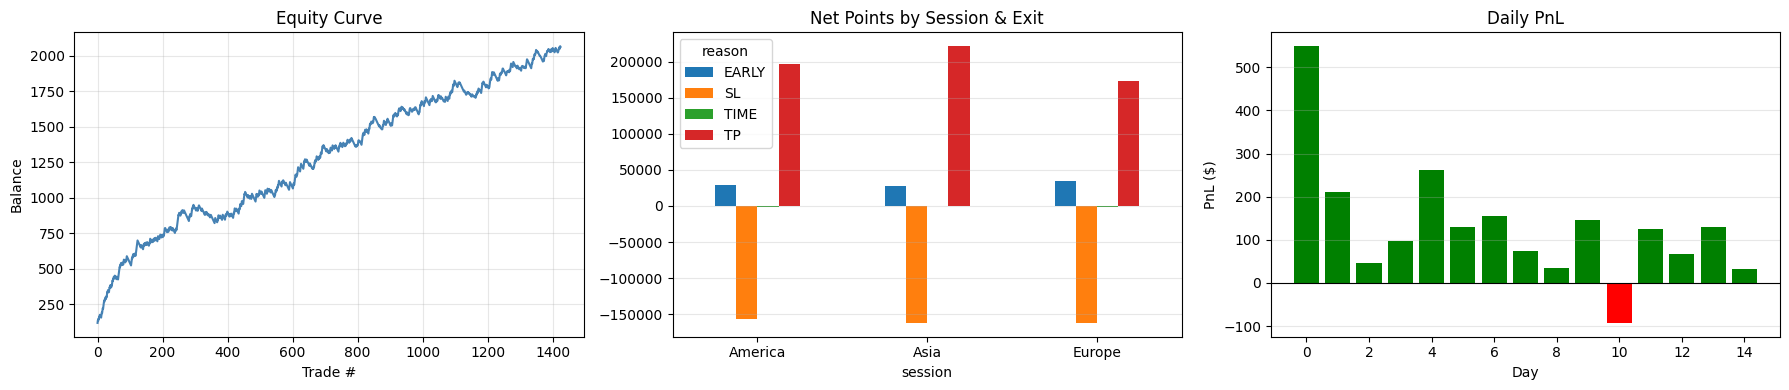

In [423]:
# ===== EDIT PARAMS HERE =====
SL_PTS        = 500
TP_PTS        = 1800
MAX_MINUTES   = 60
EARLY_MINUTES = 60
SL_TO_STOP    = 10
MAX_POSITIONS = 2
# ============================

results = run_backtest(
    records, SL_PTS, TP_PTS, MAX_MINUTES,
    EARLY_MINUTES, SL_TO_STOP, MAX_POSITIONS
)

show_dashboard(results, SL_PTS, TP_PTS, MAX_MINUTES, EARLY_MINUTES, SL_TO_STOP, MAX_POSITIONS)